In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy import wcs
from astropy.time import Time
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Set a site for where a camera could be
site = EarthLocation.of_site('Gemini South')

In [3]:
# let's read in a list of bright stars
names = ['id', 'identifier', 'typ', 'coord1', 'Mag U', 'Mag B', 'Mag V', 'Mag R', 'Mag I']
types = [int, 'U20', 'U20', 'U100', float, float, float, float]
star_data = np.genfromtxt('stars.dat', delimiter='|', comments='#', dtype=list(zip(names, types)))

In [4]:
# Read in stars and convert to astropy SkyCoord
coord_list = []
for star in star_data:
    coord_str = star['coord1']
    coord_str = coord_str.replace('+', ',+').replace('-', ',-')
    coords_str = coord_str.split(',')
    coord_list.append(SkyCoord(ra=coords_str[0]+' hours', dec=coords_str[1]+' degrees'))
# Here's a list of stars that we can use
coords = SkyCoord(coord_list)

In [5]:
# Construct a WCS to do the mapping of alt,az to x,y pixles on an all-sky camera
w = wcs.WCS(naxis=2)
# From previous all-sky fits
x0 = np.array([2.87e+03,   1.98e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])
w.wcs.crpix = [x0[0], x0[1]]
w.wcs.cdelt = [x0[2], x0[3]]
w.wcs.pc = x0[4:8].reshape((2, 2))
# Declare the ctype alt az as ALAT, ALON
w.wcs.ctype = ["ALON-ZEA", "ALAT-ZEA"]

In [6]:
# Set 3 different times to observe
mjds = np.arange(0,3,1)/24. + 35623.5 
times = Time(mjds, format='mjd')

In [7]:
# lists to hold observations
xs = []
ys = []
ras = []
decs = []
mjd_arr = []
for time in times:
    # transform stars to alt,az coords
    stars_altaz = coords.transform_to(AltAz(obstime=time, location=site))
    # Use WCS to convert to pixel coords
    x,y = w.world_to_pixel(stars_altaz.az, stars_altaz.alt)
    # only use stars that land on the chip (say it's 4kx4k) and are above the horizon
    on_chip = np.where((x > 0) & (x < 4000) & (y > 0) & (y < 4000) & (stars_altaz.alt.value > 0))[0]
    xs.append(x[on_chip])
    ys.append(y[on_chip])
    mjd_arr.append([time.mjd]*len(x[on_chip]))
    ras.append(coords.ra.value[on_chip])
    decs.append(coords.dec.value[on_chip])
xs = np.concatenate(xs)
ys = np.concatenate(ys)
mjd_arr = np.concatenate(mjd_arr)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 1 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


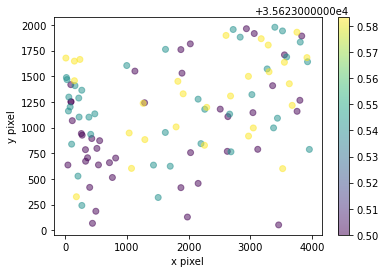

In [8]:
# plot the position of stars on the camera, color-coded by time of observation
plt.scatter(xs, ys, c=mjd_arr, alpha=0.5)
plt.xlabel('x pixel')
plt.ylabel('y pixel')
cb = plt.colorbar()

In [9]:
# Let's make sure we can convert things back
recovered_alt_az = w.pixel_to_world(xs, ys) # 
ras_back = []
decs_back = []
for mjd in np.unique(mjd_arr):
    in_time = np.where(mjd_arr == mjd)
    stars_temp = AltAz(alt=recovered_alt_az[1][in_time], az=recovered_alt_az[0][in_time],
                       location=site, obstime=Time(mjd, format='mjd'))
    stars_ra_dec_temp = stars_temp.transform_to(ICRS())
    ras_back.append(stars_ra_dec_temp.ra.value)
    decs_back.append(stars_ra_dec_temp.dec.value)
    
ras_back = np.concatenate(ras_back)
decs_back = np.concatenate(decs_back)

In [10]:
ra_resid = np.concatenate(ras) - ras_back
dec_resid = np.concatenate(decs) - decs_back

In [11]:
# ok, these should all be nice and small
ra_resid, dec_resid

(array([ 5.49427170e-11,  5.38449285e-11, -6.09361450e-11, -6.08793016e-11,
         2.76152434e-11,  1.27911015e-11, -5.79802872e-11,  4.35012026e-11,
        -6.32098818e-11, -4.92264007e-11, -5.77529136e-11, -1.59161573e-11,
         2.50337528e-11,  5.91455773e-11,  5.97886185e-11, -1.70530257e-11,
         1.97908356e-11, -2.88196134e-11,  4.50768312e-11,  2.34194886e-11,
         1.25055521e-12, -4.49063009e-12,  2.46984655e-11,  2.45563569e-11,
         5.17275112e-12,  3.46744855e-12, -1.59161573e-12,  2.54658516e-11,
        -2.54090082e-11, -1.46656021e-11, -2.34194886e-11, -4.61000127e-11,
        -2.73416845e-11, -4.22915036e-11, -4.93969310e-11, -6.05382411e-11,
        -4.35420588e-11, -6.42899067e-11,  5.01074737e-11,  4.35136371e-11,
         6.99174052e-12,  3.92219590e-12,  3.81845666e-11,  5.06901188e-11,
         1.11199938e-12, -1.39630529e-11,  4.86437557e-11,  5.09601250e-11,
         5.50812729e-11,  5.21822585e-11,  5.17133003e-11, -6.38920028e-11,
        -6.5

Text(0, 0.5, 'Dec (deg)')

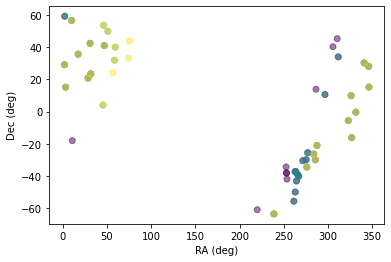

In [12]:
# most stars have three overlapping points. Some are all yellow (they were observed once and set),
# and some are purple (stars that rose and were only in the final image)
# (normally we would want to use a projection of some kind when plotting RA,Dec, but this is just a quick look)
plt.scatter(ras_back, decs_back, c=mjd_arr, alpha=.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

In [13]:
# So, we showed we can round-trip the transformation of coordinates, let's see what happens if our WCS is slightly off

w_off = wcs.WCS(naxis=2)
# Same as before, but shift the reference pixel by 200 in both x and y and fiddle with the other values too
x0 = np.array([2.87e+03 + 200,   1.98e+03 - 200,  1., 1., .036+.002,
        0.0027+.0002,  0.00295,   -0.0359])
w_off.wcs.crpix = [x0[0], x0[1]]
w_off.wcs.cdelt = [x0[2], x0[3]]
w_off.wcs.pc = x0[4:8].reshape((2, 2))

w_off.wcs.ctype = ["ALON-ZEA", "ALAT-ZEA"]

In [14]:
# same as before, only now using the slightly wrong WCS object
recovered_alt_az = w_off.pixel_to_world(xs, ys)
ras_back = []
decs_back = []
for mjd in np.unique(mjd_arr):
    in_time = np.where(mjd_arr == mjd)
    stars_temp = AltAz(alt=recovered_alt_az[1][in_time], az=recovered_alt_az[0][in_time],
                       location=site, obstime=Time(mjd, format='mjd'))
    stars_ra_dec_temp = stars_temp.transform_to(ICRS())
    ras_back.append(stars_ra_dec_temp.ra.value)
    decs_back.append(stars_ra_dec_temp.dec.value)
ras_back = np.concatenate(ras_back)
decs_back = np.concatenate(decs_back)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 1 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4334: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4431: RuntimeWarning: invalid value encountered 

Text(0, 0.5, 'Dec (deg)')

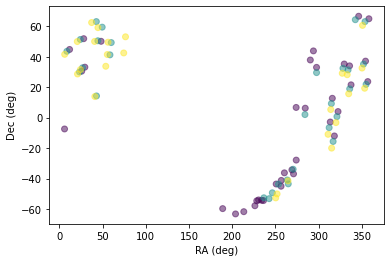

In [15]:
# Now the stars are spread out in RA,Dec because the transformation was slightly off.
plt.scatter(ras_back, decs_back, c=mjd_arr, alpha=0.5)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

So, the challenge: Can we create a function that takes arrays of star x,y,mjd values, the observatory location, and an initial WCS guess and solve for a best fitting WCS solution that maps x,y to alt,az. We can also think about including the stars' magnitude (and correcting for airmass extinction), or the precision we think we can centroid stars to. An important point is that I don't think we have to include any reference star positions!

We will need to define some statistic to minimize and pick an optimization algorithm (probably from scipy.minimize). Probably something to do with the spread of points in the RA,Dec,mjd space. The tricky part will be making sure it's fast enough. The astropy coordinate conversion calls can be slow, and it's easy to make lots of unneeded computations when computing our statistic.  The other trick is making sure our statistic is robust to stars that don't appear in multiple images (or other outliers like cosmic ray hits that are mistaken for stars). 

If we can do it, it would be a useful tool both for Rubin Observatory and the general astronomical community. The astrometry.net service specializes in fitting WCS solutions to images, but struggles with all-sky camera images. I think we could make this a contribution to astropy and they would be happy to merge it in with their code.

In [16]:
from scipy.spatial import cKDTree as kdTree


def _xyz_from_ra_dec(ra, dec):
    """
    Utility to convert RA,dec positions in x,y,z space.

    Parameters
    ----------
    ra : float or array
        RA in radians
    dec : float or array
        Dec in radians

    Returns
    -------
    x,y,z : floats or arrays
        The position of the given points on the unit sphere.
    """
    # It is ok to mix floats and numpy arrays.

    cosDec = np.cos(dec)
    return np.array([np.cos(ra) * cosDec, np.sin(ra) * cosDec, np.sin(dec)])

def buildTree(x, y, z, leafsize=100, scale=None):
    """
    Build KD tree on RA/Dec and set radius for matching.

    Parameters
    ----------
    ra, dec : float (or arrays)
        RA and Dec values (in degrees).
    leafsize : int (100)
        The number of Ra/Dec pointings in each leaf node.
    scale : float (None)
        If set, the values are scaled up, rounded, and converted to integers. Useful for
        forcing a set precision and preventing machine precision differences
    """
    
    
    data = list(zip(x, y, z))
    if np.size(data) > 0:
        try:
            tree = kdTree(data, leafsize=leafsize, balanced_tree=False, compact_nodes=False)
        except TypeError:
            tree = kdTree(data, leafsize=leafsize)
    else:
        raise ValueError('ra and dec should have length greater than 0.')

    return tree


In [17]:
# Let's make a callable object for minimizing
# Ugh, need a better name for this
class WCS_holder(object):
    """
    """
    def __init__(self, x, y, mjd, location=None, leafsize=100, clip_percentile=75.):
        self.x = x
        self.y = y
        self.mjd = mjd
        self.location = location
        self.leafsize = leafsize
        self.clip_percentile = clip_percentile
        
        # Construct the WCS object just once
        self.w = wcs.WCS(naxis=2)
        # Declare the ctype alt az as ALAT, ALON
        self.w.wcs.ctype = ["ALON-ZEA", "ALAT-ZEA"]
                        
        # list of list of indices to use later for constructing kd trees.
        self.unique_mjds = np.unique(mjds)
        self.mjd_indx_dict = {}
        self.mjd_time_dict = {}
        for date in self.unique_mjds:
            same_mjd = np.where(mjd == date)[0]
            self.mjd_indx_dict[date] = same_mjd
            self.mjd_time_dict[date] = Time(date, format='mjd')
            
        self.ra = x*0
        self.dec = x*0
        
    def x02wcs(self, x0):
        # Construct a WCS to do the mapping of alt,az to x,y pixles on an all-sky camera
        # Maybe break this out into it's own function or class for more modularity.
        self.w.wcs.crpix = [x0[0], x0[1]]
        self.w.wcs.cdelt = [x0[2], x0[3]]
        self.w.wcs.pc = x0[4:8].reshape((2, 2))
        return self.w
        
    def _xy2radec(self, w):
        """Convert the camera x,y coords to RA,dec
        """
        
        # Use the WCS to convert to alt,az
        stars_altaz = w.pixel_to_world(self.x, self.y)
        
        for mjd in self.unique_mjds:
            in_time = self.mjd_indx_dict[mjd]
            stars_temp = AltAz(alt=stars_altaz[1][in_time], az=stars_altaz[0][in_time],
                               location=self.location, obstime=self.mjd_time_dict[mjd])
            stars_ra_dec_temp = stars_temp.transform_to(ICRS())
            
            self.ra[in_time] = stars_ra_dec_temp.ra.value
            self.dec[in_time] = stars_ra_dec_temp.dec.value
        
        return self.ra, self.dec
        
        
    def __call__(self, x0):
        wcs_object = self.x02wcs(x0)
        
        ra,dec = self._xy2radec(wcs_object)
        
        
        # Generate a KD tree for each timestep
        x,y,z = _xyz_from_ra_dec(np.radians(ra), np.radians(dec))
        trees = []
        coord_dict = {}
        for key in self.mjd_indx_dict:
            indx = self.mjd_indx_dict[key]
            coords = list(zip(x[indx], y[indx], z[indx]))
            coord_dict[key] = coords
            trees.append(kdTree(coords, leafsize=self.leafsize,
                                balanced_tree=False, compact_nodes=False))
        
        distances = []
        # Let's say we look for the nearest neighbor in the image that was taken right before
        # XXX--could do lots of refinement here. Maybe should do distances to all nearby (in time) frames, 
        # or none if there are no other nearby frames.
        for i, mjd in enumerate(self.unique_mjds[:-1]):
            dd, ii = trees[i+1].query(coord_dict[mjd])
            distances.extend(dd.tolist())
        distances = np.array(distances)
        distances.sort()
        # Let's say we will clip off outliers defined as things beyond some percentile
        per_indx = np.round(distances.size*self.clip_percentile/100.)
        
        # Now to compute the mean. If we have a perfect fit, this should go to zero. 
        result = np.mean(distances[0:int(per_indx)])
        # Return the statistic we are trying to minimize
        return result

In [18]:
fitting_obj = WCS_holder(xs, ys, mjd_arr, location=site)

In [19]:
# What happens if we put in the slightly off WCS
x0 = np.array([2.87e+03 + 200,   1.98e+03 - 200,  1., 1., .036+.002,
        0.0027+.0002,  0.00295,   -0.0359])
fitting_obj(x0)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 1 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4334: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4431: RuntimeWarning: invalid value encountered 

0.0643558819270979

In [20]:
# And now the correct WCS
x0 = np.array([2.87e+03,   1.98e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])
fitting_obj(x0)

0.0027687084047568543

In [21]:
# Now let's see if scipy can minimize this
from scipy.optimize import minimize

x0_off = np.array([2.87e+03 + 200,   1.98e+03 - 200,  1., 1., .036+.002,
        0.0027+.0002,  0.00295,   -0.0359])
best_fit = minimize(fitting_obj,x0_off)

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 1 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4334: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:4431: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:18703: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154:

In [22]:
best_fit

      fun: 0.011082354828510655
 hess_inv: array([[ 5.12680629e+05,  5.65761907e+04, -3.74928737e+03,
        -1.03177976e+03,  3.28187684e+00, -5.33671804e-01,
         6.99945948e-01, -6.77699573e+00],
       [ 5.65761907e+04,  6.24341654e+03, -4.13762214e+02,
        -1.13966834e+02,  3.62271524e-01, -5.86820495e-02,
         7.76934556e-02, -7.49392521e-01],
       [-3.74928737e+03, -4.13762214e+02,  2.75673852e+01,
         7.64858099e+00, -2.41861667e-02,  3.51813668e-03,
        -6.25717864e-03,  5.03262097e-02],
       [-1.03177976e+03, -1.13966834e+02,  7.64858099e+00,
         2.52281223e+00, -7.04795733e-03,  1.78251843e-04,
        -3.44597073e-03,  1.97390464e-02],
       [ 3.28187684e+00,  3.62271524e-01, -2.41861667e-02,
        -7.04795733e-03,  3.00154857e-05,  2.33529633e-06,
         9.45206116e-06, -7.95120830e-05],
       [-5.33671804e-01, -5.86820495e-02,  3.51813668e-03,
         1.78251843e-04,  2.33529633e-06,  2.07618618e-05,
         3.22965689e-05, -2.009771

In [23]:
# Now it says "success: False", but it looks like it got really close!

In [24]:
print('result from fitting', best_fit.x)

result from fitting [ 2.77617846e+03  1.85908847e+03  6.02771124e+00  2.01891258e+00
  5.52410907e-03 -5.06451584e-04 -7.46162957e-04 -1.63155023e-02]


In [25]:
print('true values', x0)

true values [ 2.87e+03  1.98e+03  1.00e+00  1.00e+00  3.60e-02  2.70e-03  2.95e-03
 -3.59e-02]


/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "apio13" yielded 1 of "dubious year (Note 2)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Text(0, 0.5, 'dec')

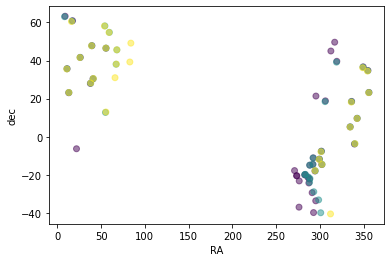

In [26]:
# let's see what this looks like
result = fitting_obj(best_fit.x)

plt.scatter(fitting_obj.ra, fitting_obj.dec, c=fitting_obj.mjd, alpha=0.5)
plt.xlabel('RA')
plt.ylabel('dec')

Text(0, 0.5, 'dec')

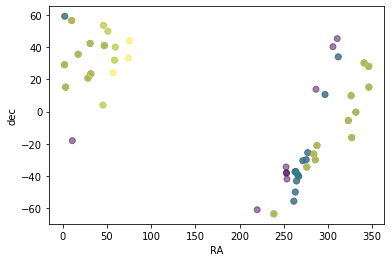

In [27]:
# And here's what the truth is. Looks like a pretty good match, except for the lower right corner. 
# 
plt.scatter(np.concatenate(ras), np.concatenate(decs), c=mjd_arr, alpha=0.5)
plt.xlabel('RA')
plt.ylabel('dec')

So, this seems to kinda work in the sense that we get a WCS solution that can take x,y chip positions and makes them overlap in RA,dec space (and, presumably that WCS object can then be called to do the reverse or RA,Dec to chip x,y).

Issues we still need to figure out:

* It seems a little slow. Might be nice to see if we can get any extra speedup
* The scipy minimize function says it failed. There are lots of different minimizers out there, and lots of options on different algorithms we can run with this one. Should figure out if we need to change the default settings, maybe set a different minimize https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
* We should think about making a more sophisticated statistic to minimize. I'm worried clipping outliers as it does now will make it unstable.  Maybe include the stellar brightnesses as an option. 
* Need to make this modular so it can use different projections. Right now ZEA is pretty hard-coded in there.
* DONE, no more mis-label--There should be a way to make a new sub-class of WCS objects that is actually for alt,az coordindates, rather than the way we are intentionally mis-labeling things now. 
* Right now, it's just matching stars to the image taken after it. We can make it check and match against all frames within some sidereal time limit.
* Once we package this up a bit, we need to test on real-world data sets!
